<a href="https://colab.research.google.com/github/dbonafilia/SGDWR-AdamWR-Keras/blob/master/Main_Training_Stuff.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [50]:
LR = 1e-4
EPOCHS = 1000
EPOCHS_PER_UPDATE = 10
RUNNAME = "TESTING_1e4_flood_3"

In [36]:
import torch
from torchvision import transforms
import torchvision.transforms.functional as F
import random

class InMemoryDataset(torch.utils.data.Dataset):
  
  def __init__(self, data_list, preprocess_func):
    self.data_list = data_list
    self.preprocess_func = preprocess_func
  
  def __getitem__(self, i):
    return self.preprocess_func(self.data_list[i])
  
  def __len__(self):
    return len(self.data_list)


def processAndAugment(data):
  (x,y) = data
  im,label = x.copy(), y.copy()

  # convert to PIL for easier transforms
  im1 = Image.fromarray(im[0])
  im2 = Image.fromarray(im[1])
  label = Image.fromarray(label.squeeze())
  #im1 = im[0]

  # Get params for random transforms
  i, j, h, w = transforms.RandomCrop.get_params(im1, (256, 256))
  
  im1 = F.crop(im1, i, j, h, w)
  im2 = F.crop(im2, i, j, h, w)
  label = F.crop(label, i, j, h, w)
  if random.random() > 0.5:
    im1 = F.hflip(im1)
    im2 = F.hflip(im2)
    label = F.hflip(label)
  if random.random() > 0.5:
    im1 = F.vflip(im1)
    im2 = F.vflip(im2)
    label = F.vflip(label)
  
  norm = transforms.Normalize([0.6851, 0.5235], [0.0820, 0.1102])
  im = norm(torch.stack([transforms.ToTensor()(im1).squeeze(), transforms.ToTensor()(im2).squeeze()]))
  label = transforms.ToTensor()(label).squeeze()
  if torch.sum(label.gt(.003) * label.lt(.004)):
    label *= 255
  label = label.round()

  return im, label


def processTestIm(data):
  (x,y) = data
  im,label = x.copy(), y.copy()
  norm = transforms.Normalize([0.6851, 0.5235], [0.0820, 0.1102])
  #label[0][0][0] = 255
  # convert to PIL for easier transforms
  im_c1 = Image.fromarray(im[0]).resize((512,512))
  im_c2 = Image.fromarray(im[1]).resize((512,512))
  label = Image.fromarray(label.squeeze()).resize((512,512))

  im_c1s = [F.crop(im_c1, 0, 0, 256, 256), F.crop(im_c1, 0, 256, 256, 256),
            F.crop(im_c1, 256, 0, 256, 256), F.crop(im_c1, 256, 256, 256, 256)]
  im_c2s = [F.crop(im_c2, 0, 0, 256, 256), F.crop(im_c2, 0, 256, 256, 256),
            F.crop(im_c2, 256, 0, 256, 256), F.crop(im_c2, 256, 256, 256, 256)]
  labels = [F.crop(label, 0, 0, 256, 256), F.crop(label, 0, 256, 256, 256),
            F.crop(label, 256, 0, 256, 256), F.crop(label, 256, 256, 256, 256)]


  ims = [torch.stack((transforms.ToTensor()(x).squeeze(),
                    transforms.ToTensor()(y).squeeze()))
                    for (x,y) in zip(im_c1s, im_c2s)]
  ims = [norm(im) for im in ims]
  ims = torch.stack(ims)
  labels = [(transforms.ToTensor()(label).squeeze()) for label in labels]
  labels = torch.stack(labels)
  if torch.sum(labels.gt(.003) * labels.lt(.004)):
    labels *= 255
  labels = labels.round()
  return ims, labels


Read in Data

In [19]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [3]:
!pip install rasterio

     |████████████████████████████████| 18.1MB 4.5MB/s eta 0:00:01


In [24]:
import csv
from PIL import Image
import rasterio
import numpy as np
import os
BASEDIR = ''

def getArr(fname):
  return rasterio.open(BASEDIR + fname).read()


def download_perm_water_data_from_file(fname):
  with open(fname) as f:
    data_fnames = [tuple(line) for line in csv.reader(f)]
  i = 0
  data = []
  for (x,y) in data_fnames:
    arr_x, arr_y = getArr(x), getArr(y)
    if np.sum((arr_x != arr_x)) == 0:
      ignore = (arr_y == -1)
      ignore = ((np.uint8(ignore) * -1) * 256) + 1
      arr_y *= ignore
      data.append((arr_x, arr_y))
      i+=1
      print(i)
    else:
      print("skipping nan")
  return data

def download_perm_train_data():
  TRAINING_DATA_FILE = BASEDIR + 'permanent_water_train_data.csv'
  return download_perm_water_data_from_file(TRAINING_DATA_FILE)

def download_perm_valid_data():
  VALID_DATA_FILE = BASEDIR + 'permanent_water_validation_data.csv'
  return download_perm_water_data_from_file(VALID_DATA_FILE)

def download_perm_test_data():
  TEST_DATA_FILE = BASEDIR + 'permanent_water_test_data.csv'
  return download_perm_water_data_from_file(TEST_DATA_FILE)


In [10]:
ls files4

flood_test_data.csv   flood_valid_data.csv  QC_v2/  S1Flood/
flood_train_data.csv  QC/                   S1/     S2/


In [9]:
!echo "deb http://packages.cloud.google.com/apt gcsfuse-bionic main" > /etc/apt/sources.list.d/gcsfuse.list
!curl https://packages.cloud.google.com/apt/doc/apt-key.gpg | apt-key add -
!apt -qq update
!apt -qq install gcsfuse

!sudo mkdir files4
!gcsfuse --implicit-dirs cnn_chips files4



/bin/sh: 1: cannot create /etc/apt/sources.list.d/gcsfuse.list: Permission denied
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   653  100   653    0     0  31095      0 --:--:-- --:--:-- --:--:-- 31095
E: This command can only be used by root.
W: chmod 0700 of directory /var/lib/apt/lists/partial failed - SetupAPTPartialDirectory (1: Operation not permitted)
E: Could not open lock file /var/lib/apt/lists/lock - open (13: Permission denied)
E: Unable to lock directory /var/lib/apt/lists/
E: Could not open lock file /var/lib/dpkg/lock - open (13: Permission denied)
E: Unable to lock the administration directory (/var/lib/dpkg/), are you root?
mkdir: cannot create directory ‘files4’: File exists
Using mount point: /home/jupyter/SGDWR-AdamWR-Keras/files4
Opening GCS connection...
Opening bucket...
Mounting file system...
File system has been successfully mounted.


In [20]:
def getArrFlood(fname):
  return rasterio.open(fname).read()

def download_flood_water_data_from_list(l):
  i= 0
  tot_nan = 0
  tot_good = 0
  flood_data = []
  for (im_fname, mask_fname) in l:
    if "Bolivia" in im_fname:
      continue
    arr_x = getArrFlood(os.path.join("files4/", im_fname))
    #print(os.path.join("/content/files4/QC_v2/", mask_fname[3:]))
    arr_y = np.uint8(getArrFlood(os.path.join("files4/QC_v2/", mask_fname[3:])))
    tot_nan += np.sum(arr_x != arr_x)
    tot_good += np.sum(arr_x == arr_x)
    if np.sum((arr_x != arr_x)) == 0:
      ignore = np.uint8((arr_y == -1))
      ignore = np.uint8(((np.uint8(ignore) * -1) * 256) + 1)
      arr_y *= ignore
      arr_x = np.clip(arr_x, -50, 1)
      arr_x = (arr_x + 50) / 51
      i += 1
      flood_data.append((arr_x,arr_y))
      print(i)
    else:
      print("skipping nan")
  print(tot_nan, tot_good)
  return flood_data

def load_flood_train_data():
  basedir = "files4/"
  fname = "files4/flood_train_data.csv"
  with open(fname) as f:
    fname = [tuple(line) for line in csv.reader(f)]
  return download_flood_water_data_from_list(fname)

def load_flood_valid_data():
  basedir = "files4/"
  fname = "files4/flood_valid_data.csv"
  with open(fname) as f:
    fname = [tuple(line) for line in csv.reader(f)]
  return download_flood_water_data_from_list(fname)

def load_flood_test_data():
  basedir = "files4/"
  fname = "files4/flood_test_data.csv"
  with open(fname) as f:
    fname = [tuple(line) for line in csv.reader(f)]
  return download_flood_water_data_from_list(fname)

In [23]:
ls /content/files4/QC/Bolivia_195474_QC.tif

ls: cannot access '/content/files4/QC/Bolivia_195474_QC.tif': No such file or directory


In [37]:
train_data = load_flood_train_data() #download_perm_train_data()
train_dataset = InMemoryDataset(train_data, processAndAugment)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=16, shuffle=True, sampler=None,
                  batch_sampler=None, num_workers=0, collate_fn=None,
                  pin_memory=True, drop_last=False, timeout=0,
                  worker_init_fn=None)
train_iter = iter(train_loader)

1
2
3
4
5
skipping nan
6
7
8
9
10
11
12
13
14
skipping nan
15
skipping nan
16
17
18
19
20
21
22
skipping nan
23
24
25
26
skipping nan
27
28
29
skipping nan
30
31
32
33
34
skipping nan
35
36
37
38
39
40
skipping nan
41
42
43
44
skipping nan
45
46
47
48
49
50
51
52
53
54
skipping nan
55
56
57
58
59
60
61
62
63
skipping nan
64
65
66
skipping nan
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
skipping nan
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
skipping nan
136
137
138
139
140
141
142
143
144
145
146
147
148
skipping nan
149
150
151
152
skipping nan
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
1803058 108821710


In [38]:
valid_data = load_flood_valid_data() #download_perm_valid_data()
valid_dataset = InMemoryDataset(valid_data, processTestIm)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=4, shuffle=True, sampler=None,
                  batch_sampler=None, num_workers=0, collate_fn=lambda x: (torch.cat([a[0] for a in x], 0), torch.cat([a[1] for a in x], 0)),
                  pin_memory=True, drop_last=False, timeout=0,
                  worker_init_fn=None)
valid_iter = iter(train_loader)

1
2
3
4
skipping nan
5
6
7
8
9
10
11
12
skipping nan
skipping nan
13
14
15
16
17
18
19
20
21
22
23
24
25
skipping nan
26
27
28
29
30
31
skipping nan
32
33
34
35
36
37
38
39
skipping nan
skipping nan
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
421894 38899706


In [39]:
test_data = load_flood_test_data()
test_dataset = InMemoryDataset(test_data, processTestIm)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=True, sampler=None,
                  batch_sampler=None, num_workers=0, collate_fn=lambda x: x[0],
                  pin_memory=True, drop_last=False, timeout=0,
                  worker_init_fn=None)
test_iter = iter(train_loader)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
skipping nan
32
skipping nan
skipping nan
33
34
35
36
37
38
39
40
41
skipping nan
42
43
44
45
46
skipping nan
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
skipping nan
69
70
71
72
73
74
75
76
77
78
79
80
skipping nan
81
82
skipping nan
83
skipping nan
84
85
skipping nan
86
skipping nan
87
88
89
skipping nan
90
91
92
93
94
95
96
skipping nan
97
98
99
100
101
102
103
104
105
skipping nan
106
107
108
skipping nan
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
1986050 74035710


Set up net/parameters

In [48]:
import torchvision.models as models
import torch.nn as nn


net = models.segmentation.fcn_resnet50(pretrained=False, num_classes=2, pretrained_backbone=False)
net.backbone.conv1 = nn.Conv2d(2, 64, kernel_size=7, stride=2, padding=3,
                               bias=False)
criterion = nn.CrossEntropyLoss(weight=torch.tensor([1,10]).float().cuda(),ignore_index=255)
optimizer = torch.optim.AdamW(net.parameters(),lr=LR)
scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, 10, T_mult=2, eta_min=0, last_epoch=-1)
def convertBNtoGN(module, num_groups=16):
  if isinstance(module, torch.nn.modules.batchnorm.BatchNorm2d):
    return nn.GroupNorm(num_groups, module.num_features,
                        eps=module.eps, affine=module.affine)
    if module.affine:
        mod.weight.data = module.weight.data.clone().detach()
        mod.bias.data = module.bias.data.clone().detach()

  for name, child in module.named_children():
      module.add_module(name, convertBNtoGN(child, num_groups=num_groups))

  return module

net = convertBNtoGN(net)
net

FCN(
  (backbone): IntermediateLayerGetter(
    (conv1): Conv2d(2, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): GroupNorm(16, 64, eps=1e-05, affine=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): GroupNorm(16, 64, eps=1e-05, affine=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): GroupNorm(16, 64, eps=1e-05, affine=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): GroupNorm(16, 256, eps=1e-05, affine=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): GroupNorm(16, 256, eps=1e-05, affine=True)
        )
  

In [43]:
#torch.load("/content/gdrive/My Drive/TESTING_1e4_flood_3_97_0.4078918397426605.cp")

{}

Utility Functions

In [26]:
def computeIOU(output, target):
  output = torch.argmax(output, dim=1).flatten() 
  target = target.flatten()
  no_ignore = target.ne(255).cuda()
  output = output.masked_select(no_ignore)
  target = target.masked_select(no_ignore)
  intersection = torch.sum(output * target)
  union = torch.sum(target) + torch.sum(output) - intersection
  return (intersection + .0000001) / (union + .0000001)
  

def computeAccuracy(output, target):
  output = torch.argmax(output, dim=1).flatten() 
  target = target.flatten()
  no_ignore = target.ne(255).cuda()
  output = output.masked_select(no_ignore)
  target = target.masked_select(no_ignore)
  correct = torch.sum(output.eq(target))
  return correct.float() / len(target)


In [27]:
test_1 = torch.ones(2, 2, 256, 256)
test_2 = torch.zeros(2, 256, 256)
test_3 = torch.ones(2, 256, 256)


print(computeIOU(test_1.cuda(), test_2.cuda()))
print(computeIOU(test_1.cuda(), test_3.cuda()))

tensor(7.6294e-13, device='cuda:0')
tensor(1., device='cuda:0')


Train/Validation functions

In [43]:

training_losses = []
training_accuracies = []
training_ious = []
valid_losses = []
valid_accuracies = []
valid_ious = []

def train(inputs, labels, net, optimizer, scheduler):
  global running_loss
  global running_iou
  global running_count
  global running_accuracy
  # zero the parameter gradients
  optimizer.zero_grad()
  net = net.cuda()
  # forward + backward + optimize
  outputs = net(inputs.cuda())
  loss = criterion(outputs["out"], labels.long().cuda())
  loss.backward()
  optimizer.step()
  scheduler.step()

  running_loss += loss
  running_iou += computeIOU(outputs["out"], labels.cuda())
  running_accuracy += computeAccuracy(outputs["out"], labels.cuda())
  running_count += 1

def validation_loop(validation_data_loader, net):
  global running_loss
  global running_iou
  global running_count
  global running_accuracy
  global max_valid_iou

  global training_losses
  global training_accuracies
  global training_ious
  global valid_losses
  global valid_accuracies
  global valid_ious

  net = net.eval()
  net = net.cuda()
  count = 0
  iou = 0
  loss = 0
  accuracy = 0
  with torch.no_grad():
      for (images, labels) in validation_data_loader:
          net = net.cuda()
          outputs = net(images.cuda())
          valid_loss = criterion(outputs["out"], labels.long().cuda())
          valid_iou = computeIOU(outputs["out"], labels.cuda())
          valid_accuracy = computeAccuracy(outputs["out"], labels.cuda())
          iou += valid_iou
          loss += valid_loss
          accuracy += valid_accuracy
          count += 1

  iou = iou / count
  accuracy = accuracy / count

  if iou > max_valid_iou:
    max_valid_iou = iou
    save_path = os.path.join(BASEDIR, "{}_{}_{}.cp".format(RUNNAME, i, iou.item()))
    #torch.save(net.state_dict(), save_path)
    print("model saved at", save_path)

  loss = loss / count
  print("Training Loss:", running_loss / running_count)
  print("Training IOU:", running_iou / running_count)
  print("Training Accuracy:", running_accuracy / running_count)
  print("Validation Loss:", loss)
  print("Validation IOU:", iou)
  print("Validation Accuracy:", accuracy)


  training_losses.append(running_loss / running_count)
  training_accuracies.append(running_accuracy / running_count)
  training_ious.append(running_iou / running_count)
  valid_losses.append(loss)
  valid_accuracies.append(accuracy)
  valid_ious.append(iou)


Train Loop

In [46]:
from tqdm.notebook import tqdm
from IPython.display import clear_output

running_loss = 0
running_iou = 0
running_count = 0
running_accuracy = 0

training_losses = []
training_accuracies = []
training_ious = []
valid_losses = []
valid_accuracies = []
valid_ious = []


def train_epoch(net, optimizer, scheduler, train_iter):
  for (inputs, labels) in tqdm(train_iter):
    train(inputs.cuda(), labels.cuda(), net.cuda(), optimizer, scheduler)
 

def train_validation_loop(net, optimizer, scheduler, train_loader,
                          valid_loader, num_epochs, cur_epoch):
  global running_loss
  global running_iou
  global running_count
  global running_accuracy
  net = net.train()
  running_loss = 0
  running_iou = 0
  running_count = 0
  running_accuracy = 0
  for i in tqdm(range(num_epochs)):
    train_iter = iter(train_loader)
    train_epoch(net, optimizer, scheduler, train_iter)
  clear_output()
  print("Current Epoch:", cur_epoch)
  validation_loop(iter(valid_loader), net)

Current Epoch: 35
Training Loss: tensor(0.3798, device='cuda:0', grad_fn=<DivBackward0>)
Training IOU: tensor(0.3417, device='cuda:0')
Training Accuracy: tensor(0.8158, device='cuda:0')
Validation Loss: tensor(0.3750, device='cuda:0')
Validation IOU: tensor(0.3381, device='cuda:0')
Validation Accuracy: tensor(0.8329, device='cuda:0')


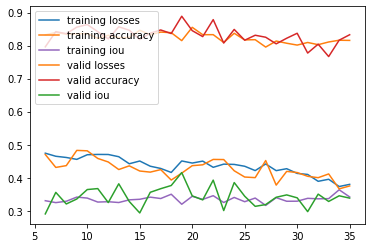

None

max valid iou: tensor(0.4154, device='cuda:0')



Test IOU: tensor(0.2202, device='cuda:0')
Test Accuracy: tensor(0.8452, device='cuda:0')


In [ ]:
import os
from IPython.display import display
import matplotlib.pyplot as plt

max_valid_iou = 0
start = 6

epochs = []
training_losses = []
training_accuracies = []
training_ious = []
valid_losses = []
valid_accuracies = []
valid_ious = []



for i in range(start, int(EPOCHS / EPOCHS_PER_UPDATE)):
  train_validation_loop(net, optimizer, scheduler, train_loader, train_loader, EPOCHS_PER_UPDATE, i)
  epochs.append(i)
  x = epochs
  plt.plot(x, training_losses, label='training losses')
  plt.plot(x, training_accuracies, 'tab:orange', label='training accuracy')
  plt.plot(x, training_ious, 'tab:purple', label='training iou')
  plt.plot(x, valid_losses, label='valid losses')
  plt.plot(x, valid_accuracies, 'tab:red',label='valid accuracy')
  plt.plot(x, valid_ious, 'tab:green',label='valid iou')
  plt.legend(loc="upper left")

  display(plt.show())

  print("max valid iou:", max_valid_iou)
  test_loop(test_loader, net)


In [ ]:
for i in range(500, 500+ int(EPOCHS / EPOCHS_PER_UPDATE)):
  train_validation_loop(net, optimizer, scheduler, train_loader, train_loader, EPOCHS_PER_UPDATE, i)
  epochs.append(i)
  x = epochs
  plt.plot(x, training_losses, label='training losses')
  plt.plot(x, training_accuracies, 'tab:orange', label='training accuracy')
  plt.plot(x, training_ious, 'tab:purple', label='training iou')
  plt.plot(x, valid_losses, label='valid losses')
  plt.plot(x, valid_accuracies, 'tab:red',label='valid accuracy')
  plt.plot(x, valid_ious, 'tab:green',label='valid iou')
  plt.legend(loc="upper left")

  display(plt.show())

  print("max valid iou:", max_valid_iou)


In [ ]:
i, l = next(iter(valid_loader))
net_out = net(i.cuda())["out"]

In [ ]:
computeIOU(net_out, l.cuda())

In [ ]:
def computeAccuracy(output, target):
  output = torch.argmax(output, dim=1).flatten() 
  target = target.flatten()
  no_ignore = target.ne(255).cuda()
  output = output.masked_select(no_ignore)
  target = target.masked_select(no_ignore)
  correct = torch.sum(output.eq(target))
  return correct.float() / len(target)

computeAccuracy(net_out[2].unsqueeze(0), l.cuda()[2].unsqueeze(0))

In [ ]:
def computeIOU(output, target):
  output = torch.argmax(output, dim=1).flatten()
  target = target.flatten()
  no_ignore = target.ne(255).cuda()
  print(output)
  print(target)
  output = output.masked_select(no_ignore)
  target = target.masked_select(no_ignore)
  print(output)
  print(target)
  intersection = torch.sum(output * target)
  union = torch.sum(target) + torch.sum(output) - intersection
  return (intersection + .0000001) / (union + .0000001)

im = Image.fromarray(np.uint8(output[0].cpu().numpy() * 255) , 'L')
computeIOU(torch.stack([net_out[3]]), torch.stack([l[3].cuda()]))

In [ ]:
print(torch.argmax(torch.stack([net_out[1]]), dim=1).flatten())
c = torch.argmax(torch.stack([net_out[3]]), dim=1)
a = torch.argmax(torch.stack([net_out[1]]), dim=1).flatten()
print(a.shape)
print(l[0].flatten().shape)
pred_wat = a.eq(1)
real_wat = l[1].flatten().cuda().eq(1)
print(a.eq(1) * (l[1].flatten().cuda().eq(1)))
inter = torch.sum(pred_wat * real_wat)
union = torch.sum(pred_wat) + torch.sum(real_wat) - inter
print(torch.sum(pred_wat * real_wat))
print(torch.sum(pred_wat) + torch.sum(real_wat))
print(torch.sum(pred_wat) + torch.sum(real_wat) / ((torch.sum(pred_wat) + torch.sum(real_wat) - torch.sum(pred_wat) + torch.sum(real_wat))))
print(inter)
print(union)
iou = inter.float() / union
print(iou)
computeIOU(torch.stack([net_out[1]]).cuda(), torch.stack([l[1]]).cuda())
print(c.squeeze())
print("match", torch.sum(c.squeeze().eq(1)))
print((c.squeeze().cpu().detach().numpy() * 255))
im = Image.fromarray((c.squeeze().cpu().detach().numpy() * 255), 'L')
im

In [ ]:
im = Image.fromarray((l[3].squeeze().cpu().detach().numpy() * 255), 'L')
im

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.colors as colors
#i, l = next(iter(valid_loader))
#print(l[0])
#i = 2
plt.imshow(i[0][0])
#plt.imshow(l[0])

In [ ]:
c = torch.argmax(torch.stack([net_out[2]]), dim=1)
c = c.squeeze().cpu().detach().numpy()
plt.imshow(c)

In [ ]:
test_dataset[0][1].shape

In [ ]:
mean = 0.
std = 0.
i = 0
total_water = 0
total_land = 0
total_mix = 0
for images, label in test_loader:
    batch_samples = images.size(0) # batch size (the last batch can have smaller size!)
    images = images.view(batch_samples, images.size(1), -1)
    if torch.sum(images != images) != 0:
      print("NAN")
      continue
    #print(images)
    #print(images.max(2))
    #print(images.min(2))
    #print(images.mean(2))
    total_water += torch.sum(label == 1)
    total_land += torch.sum(label == 0)
    total_mix += torch.sum(label == 255)
    #print(images)
    mean += images.mean(2).sum(0)
    std += images.std(2).sum(0)
    i += len(images)

mean /= i
std /= i
mean, std, total_water, total_land, total_water.float() / (total_land + total_water.float() + total_mix), total_land.float() / (total_land + total_water.float() + total_mix)


In [34]:
def test_loop(test_data_loader, net):
  net = net.eval()
  net = net.cuda()
  count = 0
  iou = 0
  loss = 0
  accuracy = 0
  with torch.no_grad():
      for (images, labels) in tqdm(test_data_loader):
          net = net.cuda()
          outputs = net(images.cuda())
          valid_loss = criterion(outputs["out"], labels.long().cuda())
          valid_iou = computeIOU(outputs["out"], labels.cuda())
          iou += valid_iou
          accuracy += computeAccuracy(outputs["out"], labels.cuda())
          count += 1

  iou = iou / count
  print("Test IOU:", iou)
  print("Test Accuracy:", accuracy / count)

test_loop(test_loader, net)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if __name__ == '__main__':



Test IOU: tensor(0.1751, device='cuda:0')
Test Accuracy: tensor(0.8133, device='cuda:0')


In [ ]:
i, l = next(iter(test_loader))

In [ ]:
net = net.cuda()
outputs = net(i.cuda())["out"]


In [ ]:
#print(torch.argmax(outputs, dim=1))
print(torch.argmax(outputs, dim=1).shape)
print(torch.sum(torch.argmax(outputs, dim=1)[4]))

plt.imshow(torch.argmax(outputs, dim=1)[4].cpu().detach().numpy())

In [ ]:
plt.imshow(l[4].cpu().detach().numpy())

In [ ]:
from PIL import Image
import os
import rasterio
import numpy as np
im = Image.fromarray(np.uint8(flood_data[4][0][1] * 255) , 'L')
print("did stuff")
im.convert("L")



In [ ]:
xf, yf = processTestIm(flood_data[0])
xp, yp = valid_dataset[1]
print(xp.unsqueeze(0).shape)
transforms.ToPILImage()(net(xp.unsqueeze(0).cuda())["out"][0].cpu())

In [ ]:
xp, yp = valid_dataset[1]
print(valid_data[0][1])
print(Image.fromarray(valid_data[1][0][0] * 255).convert("L").size)
Image.fromarray(valid_data[1][1][0] * 255).convert("L")

In [ ]:
Image.fromarray(xp[0].cpu().numpy() * 255).convert("L")

In [ ]:
#print(yp)
yp
Image.fromarray(yp.cpu().numpy() * 255).convert("L")

In [ ]:
print(yp)
Image.fromarray(yp.cpu().numpy() * 255).convert("L")

In [ ]:
def processAndAugment(data):
  (x,y) = data
  im,label = x.copy(), y.copy()

  # convert to PIL for easier transforms
  im1 = transforms.ToPILImage()(im[0])
  im2 = transforms.ToPILImage()(im[1])
  label = transforms.ToPILImage()(label.squeeze())

  # Get params for random transforms
  i, j, h, w = transforms.RandomCrop.get_params(im1, (256, 256))
  
  im1 = F.crop(im1, i, j, h, w)
  im2 = F.crop(im2, i, j, h, w)
  label = F.crop(label, i, j, h, w)
  if random.random() > 0.5:
    im1 = F.hflip(im1)
    im2 = F.hflip(im2)
    label = F.hflip(label)
  if random.random() > 0.5:
    im1 = F.vflip(im1)
    im2 = F.vflip(im2)
    label = F.vflip(label)
  
  norm = transforms.Normalize([0.6851, 0.5235], [0.0820, 0.1102])
  im = torch.stack([transforms.ToTensor()(im1).squeeze(), transforms.ToTensor()(im2).squeeze()])
  return im, transforms.ToTensor()(label).squeeze()


def processTestImspec(data):
  (x,y) = data
  im,label = x.copy(), y.copy()
  norm = transforms.Normalize([0.6851, 0.5235], [0.0820, 0.1102])
  im = torch.from_numpy(im)
  #im = norm(im)
  # convert to PIL for easier transforms
  im_c1 = transforms.ToPILImage()(im[0]).resize((512,512))
  im_c2 = transforms.ToPILImage()(im[1]).resize((512,512))
  label = transforms.ToPILImage()(label.squeeze())

  im_c1s = [F.crop(im_c1, 0, 0, 256, 256), F.crop(im_c1, 0, 256, 256, 256),
            F.crop(im_c1, 256, 0, 256, 256), F.crop(im_c1, 256, 256, 256, 256)]
  im_c2s = [F.crop(im_c2, 0, 0, 256, 256), F.crop(im_c2, 0, 256, 256, 256),
            F.crop(im_c2, 256, 0, 256, 256), F.crop(im_c2, 256, 256, 256, 256)]
  labels = [F.crop(label, 0, 0, 256, 256), F.crop(label, 0, 256, 256, 256),
            F.crop(label, 256, 0, 256, 256), F.crop(label, 256, 256, 256, 256)]


  ims = [torch.stack((transforms.ToTensor()(x).squeeze(),
                    transforms.ToTensor()(y).squeeze()))
                    for (x,y) in zip(im_c1s, im_c2s)]
  ims = torch.stack([norm(im) for im in ims])
  labels = [transforms.ToTensor()(label).squeeze() for label in labels]
  labels = torch.stack(labels)
  return ims[0], labels


xp, yp = processTestIm(flood_data[1])
#xp, yp = next(iter(test_loader))
print(xp.shape)
print(xp[1])
Image.fromarray(xp[1][0].cpu().numpy() * 255).convert("L")

In [ ]:
Image.fromarray(yp[3].cpu().numpy() * 255).convert("L")

In [ ]:
print(flood_data[1][1].shape)
Image.fromarray(flood_data[1][1][0] * 255).convert("L")

In [ ]:
print(flood_data[1][1].shape)
#im2 = transforms.ToTensor()(transforms.ToPILImage()(flood_data[1][1].squeeze()))
im2 = torch.from_numpy(flood_data[1][1].squeeze())
print(im2.cpu().numpy().shape)
print(im2.cpu().numpy())
print(flood_data[1][1].shape)
print(flood_data[1][1])
print(im2.cpu().numpy().dtype)
print(flood_data[1][1].dtype)
print(im2.cpu().numpy().shape)
print(flood_data[1][1][0].shape)

print(im2.cpu().numpy().round() == flood_data[1][1][0].round())
print(np.sum((im2.cpu().numpy()[0].round() != flood_data[1][1][0].round())))
Image.fromarray(im2.cpu().numpy() * 255).convert("L")

In [ ]:
next(iter(test_loader))[0].shape

In [ ]:
transforms.ToPILImage()(net(xp.cuda())["out"][0].cpu())

In [ ]:
im = Image.fromarray(np.uint8(train_data[0][0][0] * 255) , 'L')
print("did stuff")
im.convert("L")



In [ ]:
im = Image.fromarray(np.uint8(train_data[0][1][0] * 255) , 'L')
print("did stuff")
im.convert("L")


In [ ]:
test_dataset[0]

In [ ]:
l.shape

In [ ]:
i, l = valid_dataset[0]
print(valid_file)
im = Image.fromarray(np.uint8(l * 255) , 'L')
im

In [ ]:
#im = Image.fromarray(np.uint8(i[1][1] * 255) , 'L')
print(i.numpy()[0].shape)
im = Image.fromarray(i[0][0].cpu().numpy(), 'L')
im

In [ ]:
len(train_dataset)

In [ ]:
a = train_data[50][0][1]
im = Image.fromarray((a * 255), "L")
im

In [ ]:
def download_flood_water_data_from_list(l):
  i= 0
  tot_nan = 0
  tot_good = 0
  flood_data = []
  for (im_fname, mask_fname) in l:
    arr_x = getArrFlood(os.path.join("/content/files4/S1", im_fname))
    print(os.path.join("/content/files4/QC_v2", mask_fname))
    arr_y = np.uint8(getArrFlood(os.path.join("/content/files4/QC_v2", mask_fname)))
    tot_nan += np.sum(arr_x != arr_x)
    tot_good += np.sum(arr_x == arr_x)
    if np.sum((arr_x != arr_x)) == 0:
      ignore = np.uint8((arr_y == -1))
      ignore = np.uint8(((np.uint8(ignore) * -1) * 256) + 1)
      arr_y *= ignore
      arr_x = np.clip(arr_x, -50, 1)
      arr_x = (arr_x + 50) / 51
      i += 1
      flood_data.append((arr_x,arr_y))
      print(i)
    else:
      print("skipping nan")
  print(tot_nan, tot_good)
  return flood_data


In [ ]:
arr_x = getArrFlood(os.path.join("/content/files4/S1", "India_179238_S1.tif"))
arr_x

In [ ]:
arr_x = np.clip(arr_x, -50, 1)
arr_x = (arr_x + 50) / 51
print(arr_x)
Image.fromarray(arr_x[0] * 255, "L")